In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
#@markdown <h3> Copied code for setup </h3>
#!python -m pip install torch==1.11.0+cu102 torchvision==0.12.0+cu102 pytorch-lightning  torchtext -f https://download.pytorch.org/whl/torch_stable.html

!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 pytorch-lightning --extra-index-url https://download.pytorch.org/whl/cu117
!python -m  install scipy==1.5.4
!python -m  install numpy==1.19.5
!python -m  install tqdm
!python -m  install pytorch-fid==0.2.0
!python -m  install pandas==1.1.5
!python -m  install lpips==0.1.4
!python -m  install lmdb==1.2.1
!python -m  install ftfy
!python -m  install regex
!python -m  install dlib requests


!git clone https://github.com/phizaz/diffae
!git pull https://github.com/phizaz/diffae



%cd 'diffae'

In [ ]:
#!pip install torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install pip install lmdb

In [ ]:
!pip install pytorch_fid
!pip install lpips

In [ ]:
import torch
#torch.backends.cudnn.benchmark = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')#@markdown <h3> 🔧 Import libraries and tools </h3>

import os
import os.path as osp
import matplotlib.pyplot as plt

from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

def show_images(images, cols = 1, titles = None, apply_convert=False):
    if apply_convert: images = [convert(img) for img in images]
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, int(np.ceil(n_images/float(cols))), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images*2)
    plt.show()

def convert2rgb(img,adjust_scale=True):
    convert_img = torch.tensor(img)
    if adjust_scale: convert_img = (convert_img+1)/2
    return (convert_img).permute(1, 2, 0).cpu()

In [ ]:
device = 'cuda'
conf = ffhq256_autoenc()
# print(conf.name)
pretrained_encoder = LitModel(conf)
state = torch.load("", map_location='cpu')
pretrained_encoder.load_state_dict(state['state_dict'], strict=False)
pretrained_encoder.ema_model.eval()
pretrained_encoder.ema_model.to(device);



create semantic subcodes

In [ ]:
img_loc = ""
images = torch.load(img_loc, map_location = "cpu")

In [ ]:
len(images)

In [ ]:
df_loc = ""

target_df = pd.read_excel(df_loc)

#target_df.drop(2015, inplace = True)

In [ ]:
len(target_df), len(images)

In [ ]:
res_lis = []
valid_idx_lis = []

for i, s in enumerate(target_df["price"]):
  try:
    if type(s) == str:
      s = s[1:]
      s = s.replace(",", "")
      res_lis.append(float(s))
      valid_idx_lis.append(i)
  except:
    print(s)

targets = torch.tensor(res_lis)
images = images[valid_idx_lis]


In [ ]:
minimum = torch.quantile(targets, 0.05)
maximum = torch.quantile(targets, 1 - 0.05)
valid_idx2 = torch.logical_and(targets > minimum, targets < maximum)

In [ ]:
targets = targets[valid_idx2]
images = images[valid_idx2]

In [ ]:
targets = torch.log(targets)

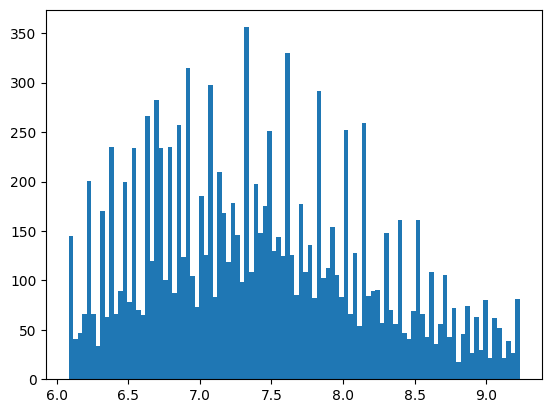

In [ ]:
plt.hist(targets, bins = 100)
plt.show()

## Preprocess DataFrame


In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")


imputer = imputer.fit(
    target_df[
        [
            "accommodates",
            "bedrooms",
            "number_of_reviews",
            "review_scores_value",
            "minimum_nights",
        ]
    ]
)

target_df[
    [
        "accommodates",
        "bedrooms",
        "number_of_reviews",
        "review_scores_value",
        "minimum_nights",
    ]
] = imputer.transform(
    target_df[
        [
            "accommodates",
            "bedrooms",
            "number_of_reviews",
            "review_scores_value",
            "minimum_nights",
        ]
    ]
)

In [ ]:
target_df = target_df.reset_index(drop=True)

In [ ]:
target_df = target_df[valid_idx2.numpy()]

In [ ]:
train_df = target_df.reset_index(drop=True)
train_df = train_df[
    [
        #"host_is_superhost",
        #"latitude",
        #"longitude",
        "room_type",
        "accommodates",
        "bedrooms",
        "minimum_nights",
        "number_of_reviews",
        "review_scores_value",
        "host_identity_verified",
    ]
]


In [ ]:
from copy import deepcopy
train_df_unscaled = deepcopy(train_df)

In [ ]:

def normalize_df(df):
  df = (df - df.mean())/df.std()
  return df

def min_max_df(df):
  df = min_max_scaler.fit_transform(df)
  return df



def transform_data2(df):
  num_cols = [dt.kind != "O" for dt in df.dtypes]

  df[df.columns.values[num_cols]] = normalize_df(df[df.columns.values[num_cols]])
  df = pd.get_dummies(df)

  return df

In [ ]:
train_df_unscaled = pd.get_dummies(train_df_unscaled)

In [ ]:
train_df = transform_data2(train_df)

In [ ]:
features = np.array(train_df)
col_names = list(train_df.keys())

## Define NAM

In [ ]:
class FeatureNN(torch.nn.Module):
    def __init__(self,
                 shallow_units: int,   # number of neurons in first layer
                 hidden_units = [],  # tuple of numbers of hidden units
                 activation = torch.nn.ReLU(),
                 dropout: float = .5,
                 ):
        super().__init__()

        # Define Layers
        self.layers = torch.nn.ModuleList([
            torch.nn.Linear(shallow_units if i == 0 else hidden_units[i - 1], hidden_units[i])
            for i in range(len(hidden_units))
        ])

        self.layers.insert(0, torch.nn.Linear(1, shallow_units))
        self.output_layer = torch.nn.Linear(hidden_units[-1], 1)

        # Dropout and activation
        self.dropout = torch.nn.Dropout(p=dropout)
        self.activation = activation


    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            x = self.activation(x)
            x = self.dropout(x)
        x = self.output_layer(x)
        return x


class NAM(torch.nn.Module):
  def __init__(self,
                n_features,
                shallow_units: int,   # number of neurons in first layer
                hidden_units = [],  # tuple of numbers of hidden units
                activation = torch.nn.ReLU(),
                dropout: float = .5,
                feature_dropout = 0.0,
                return_output_lis = False
                ):
      super().__init__()

      self.shallow_units = shallow_units
      self.hidden_units = hidden_units
      self.activation = activation
      self.dropout = dropout

      self.n_features = n_features
      self.feature_dropout_rate = feature_dropout
      self.return_output_lis = return_output_lis

      self.feature_nns = torch.nn.ModuleList([
            FeatureNN(shallow_units=shallow_units,
                      hidden_units=hidden_units,
                      activation=activation,
                      dropout=dropout)
            for i in range(n_features)
        ])

      self.bias = torch.nn.Parameter(torch.zeros(1))
      self.feature_dropout = torch.nn.Dropout(p=self.feature_dropout_rate)

  def forward(self, x, f):
    eta = self.bias
    output_lis = []
    for feature, mod in zip(f.T, self.feature_nns):
      feature = feature.unsqueeze(-1)
      ri = mod(feature)
      output_lis.append(ri)

    if self.return_output_lis:
      return output_lis

    else:
       conc_out = torch.cat(output_lis, dim=-1)
       dropout_out = self.feature_dropout(conc_out)
       out = torch.sum(dropout_out, dim=-1) + self.bias

       return out


class NAM_plus_CNN(torch.nn.Module):
  def __init__(self,
                pretrained_encoder,
                mlp,
                feat_nam,
                ):
      super().__init__()

      self.pretrained_encoder = pretrained_encoder
      self.mlp = mlp
      self.feat_nam = feat_nam
      self.feat_nam.return_output_lis = True

  def forward(self, image, features):
    output_lis_nam = self.feat_nam(_, features)

    res_cnn = self.pretrained_encoder.encode(image)
    res_cnn = self.mlp(res_cnn)

    output_lis = output_lis_nam + [res_cnn]
    output_lis = torch.cat(output_lis, dim=-1)


    output_lis = self.feat_nam.feature_dropout(output_lis)
    out = torch.sum(output_lis, dim=-1) + self.feat_nam.bias
    return out

In [ ]:
img_shape = images[0][0].shape
img_shape

torch.Size([256, 256])

In [ ]:
#mean = torch.mean(images, dim = 0)
#std = torch.std(images, dim = 0)

image_size = conf.img_size

transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomApply([torchvision.transforms.ColorJitter(brightness = (0.8, 1.3))], p=0.5),
    torchvision.transforms.RandomApply([torchvision.transforms.ColorJitter(contrast = (0.8, 1.3))], p=0.5),
    #torchvision.transforms.RandomApply([torchvision.transforms.ColorJitter(saturation = (0.5, 1.5))], p=0.5),   # Skin color?
    #torchvision.transforms.RandomApply([torchvision.transforms.Grayscale()], p = 0.1),
    torchvision.transforms.RandomApply([torchvision.transforms.GaussianBlur(kernel_size = 11)], p = 0.2),
    torchvision.transforms.Resize(image_size),
    torchvision.transforms.CenterCrop(image_size)
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transforms_val_test = torchvision.transforms.Compose([
     torchvision.transforms.Resize(image_size),
     torchvision.transforms.CenterCrop(image_size)
     #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""
    def __init__(self, img_ten, label_ten, transforms=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_ten = img_ten
        self.label_ten = label_ten
        self.transforms = transforms

        assert len(img_ten) == len(label_ten), "img_ten and label ten must have equal size"
    def __len__(self):
      return len(self.img_ten)

    def __getitem__(self, idx):
      x = self.img_ten[idx]
      y = self.label_ten[idx]

      if not self.transforms == None:
        x = self.transforms(x)

      return x, y

    def set_transforms(self, transforms):
      self.transforms = transforms


In [ ]:
class CustomDataset_img_features(torch.utils.data.Dataset):
    """Face Landmarks dataset."""
    def __init__(self, img_ten, feature_ten, label_ten, transforms=None):

        self.img_ten = img_ten
        self.label_ten = label_ten
        self.feature_ten = feature_ten
        self.transforms = transforms

        assert len(img_ten) == len(label_ten) ==  len(feature_ten), "img_ten and and feature_ten and label ten must have equal size"
    def __len__(self):
      return len(self.img_ten)

    def __getitem__(self, idx):
      x = self.img_ten[idx]
      feat = self.feature_ten[idx]
      y = self.label_ten[idx]

      if not self.transforms == None:
        x = self.transforms(x)

      return x, feat, y

    def set_transforms(self, transforms):
      self.transforms = transforms

In [1]:
def train_test_split_images(images, targets, train_frac, val_frac, batch_size, transforms_train, transforms_val_test):
    tot_len = len(images)

    train_max_idx = int(tot_len*train_frac)
    val_max_idx = int(tot_len*val_frac) + train_max_idx

    train_img = images[:train_max_idx]
    train_y = targets[:train_max_idx]

    val_img = images[train_max_idx:val_max_idx]
    val_y = targets[train_max_idx:val_max_idx]

    test_img = images[val_max_idx:]
    test_y = targets[val_max_idx:]

    train_set = CustomDataset(train_img, train_y, transforms = transforms_train)
    val_set = CustomDataset(val_img, val_y, transforms = transforms_val_test)
    test_set = CustomDataset(test_img, test_y, transforms = transforms_val_test)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle=True)

    return train_loader, val_loader, test_loader


def train_test_split_features(features, targets, train_frac, val_frac, batch_size):
    tot_len = len(features)

    train_max_idx = int(tot_len*train_frac)
    val_max_idx = int(tot_len*val_frac) + train_max_idx

    train_features = features[:train_max_idx]
    train_y = targets[:train_max_idx]

    val_features = features[train_max_idx:val_max_idx]
    val_y = targets[train_max_idx:val_max_idx]

    test_features = features[val_max_idx:]
    test_y = targets[val_max_idx:]

    train_set = list(zip(train_features, train_y))
    val_set = list(zip(val_features, val_y))
    test_set = list(zip(test_features, test_y))

    train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle=True)

    return train_loader, val_loader, test_loader


def train_test_split_features_images(features, images, targets, train_frac, val_frac, batch_size, transforms_train, transforms_val_test):
    tot_len = len(features)

    train_max_idx = int(tot_len*train_frac)
    val_max_idx = int(tot_len*val_frac) + train_max_idx

    train_features = features[:train_max_idx]
    train_images = images[:train_max_idx]
    train_y = targets[:train_max_idx]

    val_features = features[train_max_idx:val_max_idx]
    val_images = images[train_max_idx:val_max_idx]
    val_y = targets[train_max_idx:val_max_idx]

    test_features = features[val_max_idx:]
    test_images = images[val_max_idx:]
    test_y = targets[val_max_idx:]

    train_set = CustomDataset_img_features(train_images, train_features, train_y, transforms = transforms_train)
    val_set = CustomDataset_img_features(val_images, val_features, val_y, transforms = transforms_val_test)
    test_set = CustomDataset_img_features(test_images, test_features, test_y, transforms = transforms_val_test)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle=True)

    return train_loader, val_loader, test_loader



In [ ]:
y_mean = torch.mean(targets)
y_std = torch.std(targets)

standardize_targets = lambda x: (x - y_mean)/y_std
unstandardize_targets = lambda x: x*y_std + y_mean
unstandardize_and_exp_targets = lambda x: torch.exp(x*y_std + y_mean)

targets_standardized = (targets - y_mean)/y_std


In [ ]:
train_loader, val_loader, test_loader = train_test_split_features_images(images = images,
                                                         features = torch.tensor(features).float(),
                                                         targets = torch.tensor(targets_standardized).float(),
                                                         train_frac = 0.7,
                                                         val_frac = 0.2,
                                                         batch_size = 128,
                                                         transforms_train= transforms_train,
                                                         transforms_val_test = transforms_val_test)   # create dataloader with embeddings

<ipython-input-38-9772b75213fe>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets_standardized).float(),


In [ ]:
class One_Layer_MLP(torch.nn.Module):
  def __init__(self,  n_input_units):

    super(One_Layer_MLP, self).__init__()

    self.n_input_units = n_input_units
    self.fc1 = torch.nn.Linear(n_input_units, 1)

  def forward(self, x):

    x = self.fc1(x)
    return x


class Linear_skip_block(nn.Module):
  """
  Block of linear layer + softplus + skip connection +  dropout  + batchnorm
  """
  def __init__(self, n_input, dropout_rate):
    super(Linear_skip_block, self).__init__()

    self.fc = nn.Linear(n_input, n_input)
    self.act = torch.nn.LeakyReLU()

    self.bn = nn.BatchNorm1d(n_input, affine = True)
    self.drop = nn.Dropout(dropout_rate)

  def forward(self, x):
    x0 = x
    x = self.fc(x)
    x = self.act(x)
    x = x0 + x
    x = self.drop(x)
    x = self.bn(x)

    return x

class Linear_block(nn.Module):
  """
  Block of linear layer dropout  + batchnorm
  """
  def __init__(self, n_input, n_output, dropout_rate):
    super(Linear_block, self).__init__()

    self.fc = nn.Linear(n_input, n_output)
    self.act = torch.nn.LeakyReLU()
    self.bn = nn.BatchNorm1d(n_output, affine = True)
    self.drop = nn.Dropout(dropout_rate)

  def forward(self, x):
    x = self.fc(x)
    x = self.act(x)
    x = self.drop(x)
    x = self.bn(x)

    return x

class MLP(nn.Module):
  def __init__(self, n_input_units, n_hidden_units, n_skip_layers, dropout_rate):

    super(MLP, self).__init__()
    self.n_input_units = n_input_units
    self.n_hidden_units = n_hidden_units
    self.n_skip_layers = n_skip_layers
    self.dropout_rate = dropout_rate

    self.linear1 = Linear_block(n_input_units, n_hidden_units, dropout_rate)    # initial linear layer
    self.hidden_layers = torch.nn.Sequential(*[Linear_skip_block(n_hidden_units, dropout_rate) for _ in range(n_skip_layers)])  #hidden skip-layers

    self.linear_final =  torch.nn.Linear(n_hidden_units, 1)

  def forward(self, x):
    x = self.linear1(x)
    x = self.hidden_layers(x)
    x = self.linear_final(x)

    return(x)

class CNN(nn.Module):
  def __init__(self, pretrained_model, mlp):
    super(CNN, self).__init__()

    self.pretrained_model = pretrained_model
    self.pretrained_model.requires_grad = False
    self.mlp = mlp

  def forward(self, x, f):
    with torch.no_grad():
      x = self.pretrained_model.encode(x)
    x = self.mlp(x)

    return x

In [ ]:
def var_exp_score(predictions, targets):
  mean_sum_of_squares = torch.mean((predictions - targets)**2)
  variance_targets = torch.var(targets)
  var_exp = 1- mean_sum_of_squares/variance_targets

  return var_exp

def coef_det(x, y):
  sum_x = torch.sum(x)
  sum_y = torch.sum(y)
  n = len(x)

  numerator = n * torch.sum(x * y) - sum_x*sum_x
  denominator = (n * torch.sum(x**2) - sum_x**2)**0.5 * (n * torch.sum(y**2) - sum_y**2)**0.5

  return numerator/denominator


def mad_explained(predictions, targets):
  mean_sum_of_ad = torch.mean(torch.abs(predictions - targets))
  deviation_median = torch.mean(torch.abs(targets - torch.median(targets)))

  mad_exp = 1 - mean_sum_of_ad/deviation_median

  return mad_exp

In [ ]:
import numpy as np
import time
from tqdm import tqdm
#Validation function

def validate(model, dataloader, loss_fun):
    val_loss_lis = []

    target_lis = []
    pred_lis = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:

          x, f, y = batch
          x = x.to(device)
          f = f.to(device)
          y = y.to(device)
          pred = model(x, f)
          pred = pred.squeeze(-1)
          loss = loss_fun(pred, y)
          val_loss_lis.append(loss.cpu().detach())

          target_lis.append(y.detach().cpu())
          pred_lis.append(pred.detach().cpu())

    mean_loss = np.mean(np.array(val_loss_lis))
    median_loss = np.median(np.array(val_loss_lis))

    target_ten, pred_ten = torch.cat(target_lis), torch.cat(pred_lis)
    var_exp = var_exp_score(pred_ten, target_ten)
    mad_exp = mad_explained(pred_ten, target_ten)
    r_score = coef_det(pred_ten, target_ten)
    return mean_loss, median_loss, var_exp, mad_exp, r_score



# Training function
def train_loop(model, optimizer, loss_fun, trainset, valset, print_mod, device, n_epochs, save_path = None, early_stopping = True, n_epochs_early_stopping = 5):
    """
    train the model
    Args:
        model: The model to train
        optimizer: The used optimizer
        loss_fun: The used loss function
        trainset: The dataset to train on
        valset: The dataset to use for validation
        print_mod: Number of epochs to print result after
        device: Either "cpu" or "cuda"
        n_epochs: Number of epochs to train
        save_path: Path to save the model's state dict
        config: config file from the model to train
        sparse_ten (bool): if a sparse tensor is used for each batch
    """
    if early_stopping == True:
      n_early_stopping = n_epochs_early_stopping
      past_val_losses = []

    loss_lis = []
    target_lis = []
    pred_lis = []

    loss_lis_all = []
    val_loss_lis_all = []

    model = model.to(device)

    model.train()
    for epoch in range(n_epochs):
      start = time.time()
      for iter, batch in enumerate(tqdm(trainset)):

        x, f, y = batch
        x = x.to(device)
        f = f.to(device)
        y = y.to(device)
        pred = model(x, f)
        pred = pred.squeeze(-1)


        loss = loss_fun(pred, y)
        #print(loss)

        optimizer.zero_grad()       # clear previous gradients
        loss.backward()             # backprop

        optimizer.step()

        loss_lis.append(loss.cpu().detach())
        target_lis.append(y.detach().cpu())
        pred_lis.append(pred.detach().cpu())

      if epoch % print_mod == 0:

        end = time.time()
        time_delta = end - start

        mean_loss = np.mean(np.array(loss_lis))
        median_loss = np.median(np.array(loss_lis))

        target_ten, pred_ten = torch.cat(target_lis), torch.cat(pred_lis)
        var_exp = var_exp_score(pred_ten, target_ten)
        mad_exp = mad_explained(pred_ten, target_ten)
        r_score = coef_det(pred_ten, target_ten)

        target_lis = []
        pred_lis = []



        loss_lis_all += loss_lis

        loss_lis = []



        mean_loss_val, median_loss_val, var_exp_val, mad_exp_val, val_r_score = validate(model, val_loader, loss_fun = loss_fun)

        val_loss_lis_all.append(mean_loss_val)



        print(f'Epoch nr {epoch}: mean_train_loss = {mean_loss}, median_train_loss = {median_loss}, train_var_exp = {var_exp}, train_mad_exp = {mad_exp}, train_r = {r_score}, elapsed time: {time_delta}')
        print(f'Epoch nr {epoch}: mean_valid_loss = {mean_loss_val}, median_valid_loss = {median_loss_val}, valid_var_exp = {var_exp_val}, valid_mad_exp = {mad_exp_val},  valid_r = {val_r_score}')



        # early stopping based on median validation loss:
        if early_stopping:
          if len(past_val_losses) == 0 or mean_loss_val < min(past_val_losses):
            print("save model")
            torch.save(model.state_dict(), save_path)

          if len(past_val_losses) >= n_early_stopping:
            if mean_loss_val > max(past_val_losses):
              print(f"Early stopping because the median validation loss has not decreased since the last {n_early_stopping} epochs")
              return loss_lis_all, val_loss_lis_all
            else:
              past_val_losses = past_val_losses[1:] + [mean_loss_val]
          else:
            past_val_losses = past_val_losses + [mean_loss_val]



    return loss_lis_all, val_loss_lis_all

In [ ]:
from ast import Name


save_path = ""

mlp = MLP(n_input_units = 512,
    n_hidden_units = 500,
    n_skip_layers = 4,
    dropout_rate = 0.5)

#model_cnn = CNN(
#    pretrained_model = pretrained_encoder,
#    mlp = mlp

#)


nam = NAM(n_features=features.shape[-1],
                            shallow_units=20,
                            hidden_units=(100, 100, 100),
                            activation= torch.nn.ReLU(),
                            dropout=0.5,
                            feature_dropout = 0.5
          )
model = NAM_plus_CNN(pretrained_encoder, mlp, nam)

# Train MLP-head and NAM jointly

In [ ]:
sdf

In [ ]:
lr = 1e-3
opt = torch.optim.AdamW(list(model.mlp.parameters()) + list(model.feat_nam.parameters()), lr = lr, weight_decay=1e-3)
#opt = torch.optim.AdamW(model.parameters(), lr = lr, weight_decay=1e-3)

In [ ]:


train_loop(model = model,
           optimizer = opt,
           loss_fun = torch.nn.MSELoss(),     #torch.nn.L1Loss4
           trainset = train_loader,
           valset = val_loader,
           print_mod = 1,
           device = device,
           early_stopping = True,
           n_epochs_early_stopping = 100,
           save_path = save_path,
           n_epochs = 10000)

In [ ]:
model.load_state_dict(torch.load(save_path))

In [ ]:
model = model.eval().to(device)

In [ ]:
validate(model, test_loader, torch.nn.MSELoss())

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

def plot_feature_nn(feature_nn, x_vals_compute, bias, x_vals_to_plot, ax=None, y_data=None, unscale_fun=None, q = 0):


    with sns.axes_style('whitegrid'):
      with sns.color_palette('dark'):

        max_fun = lambda x: np.quantile(x, q = 1-q)
        min_fun = lambda x: np.quantile(x, q = q)

        valid_idx = (x_vals_compute >= min_fun(x_vals_compute)) & (x_vals_compute <= max_fun(x_vals_compute))
        print((np.mean(valid_idx)))
        print(len(x_vals_compute))
        print(len(x_vals_to_plot))

        x_vals_compute = x_vals_compute[valid_idx]
        x_vals_to_plot = x_vals_to_plot[valid_idx]
        y_data = y_data[valid_idx]




        min_compute = min(x_vals_compute)
        max_compute = max(x_vals_compute)
        range_compute = np.linspace(min_compute, max_compute, 1000)

        min_plot = min(x_vals_to_plot)
        max_plot = max(x_vals_to_plot)
        range_plot = np.linspace(min_plot, max_plot, 1000)

        feature_nn = feature_nn.eval()
        with torch.no_grad():
            model_input = torch.tensor(range_compute).to(device).reshape(-1, 1).float()
            y_pred = feature_nn(model_input) + bias

            if not unscale_fun is None:
                y_pred = unscale_fun(y_pred)
                y_data = unscale_fun(y_data)

            if ax is None:
                fig, ax = plt.subplots(figsize=(10, 10))
            else:
                fig = plt.gcf()

            fig.set_size_inches(30/2, 10.5/2)
            # Plot the model prediction
            sns.lineplot(x=range_plot, y=y_pred.squeeze().cpu().numpy(), color="r", label="Model Prediction", linewidth=2)

            # Plot the training data
            if y_data is not None:
                sns.scatterplot(x=x_vals_to_plot, y=y_data, color="blue", alpha=0.3, s = 5, label="Training Data", ax=ax)

            # Customize the plot
            ax.set_xlabel("X", fontsize=15)
            ax.set_ylabel("Y", fontsize=15)
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_linewidth(1.5)
            ax.spines["left"].set_linewidth(1.5)
            ax.tick_params(axis='both', which='major', labelsize=15, width=1.5)
            #ax.set_xticks(fontsize=15)

            # Add a title and legend
            #ax.set_title("Feature Neural Network", fontsize=20)
            ax.legend(fontsize=20, frameon=True)

            # Add a grid
            ax.grid(True, alpha=0.3)

            plt.tight_layout()

            return fig, ax



In [ ]:

for idx, name in enumerate(col_names):
  unscale_fun = unstandardize_and_exp_targets

  fig, ax = plot_feature_nn(model.feat_nam.feature_nns[idx], features[:, idx], bias = model.feat_nam.bias.item(), x_vals_to_plot = train_df_unscaled[name], y_data = targets_standardized, unscale_fun = unscale_fun, q= 0)
  ax.set_title(f"{name}")
  ax.set_xlabel(f"{name}", fontsize=14)
  ax.set_ylabel("Y", fontsize=14)

In [ ]:
col_names

In [ ]:
col_name = "review_scores_value"
plot_title = "Value of Review Scores"
idx = col_names.index(col_name)

unscale_fun = unstandardize_and_exp_targets

fig, ax = plot_feature_nn(model.feat_nam.feature_nns[idx], features[:, idx], bias = model.feat_nam.bias.item(), x_vals_to_plot = train_df_unscaled[col_name], y_data = targets_standardized, unscale_fun = unscale_fun,q = 0.01)


ax.set_title(f"{plot_title}", fontsize=20)
ax.set_xlabel(f"{plot_title}", fontsize = 20)
ax.set_ylabel("Price in ZAR", fontsize = 20)
fig.set_size_inches(10, 6.66)

plt.savefig(f'save_path/{col_name}.png',  bbox_inches='tight', dpi = 1000)
plt.show()

In [ ]:
plt.savefig(f'save_path/_{i_idx}_{j_idx}.png')

In [ ]:
lr = 1e-4
#opt = torch.optim.AdamW(list(model.mlp.parameters()) + list(model.feat_nam.parameters()), lr = lr, weight_decay=1e-3)
opt = torch.optim.AdamW(model.mlp.parameters(), lr = lr, weight_decay=1e-3)

In [ ]:
# fine-tune just MLP

train_loop(model = model,
           optimizer = opt,
           loss_fun = torch.nn.MSELoss(),     #torch.nn.L1Loss4
           trainset = train_loader,
           valset = val_loader,
           print_mod = 1,
           device = device,
           early_stopping = True,
           n_epochs_early_stopping = 100,
           save_path = save_path,
           n_epochs = 10000)

# Train MLP-head first and then NAM

In [ ]:

mlp = MLP(n_input_units = 512,
    n_hidden_units = 500,
    n_skip_layers = 4,
    dropout_rate = 0.5)

model_cnn = CNN(
    pretrained_model = pretrained_encoder,
    mlp = mlp

)

nam = NAM(n_features=features.shape[-1],
                            shallow_units=20,
                            hidden_units=(20, 20, 20),
                            activation= torch.nn.ReLU(),
                            dropout=0.3)


In [ ]:
nam_plus_cnn = NAM_plus_CNN(pretrained_encoder, mlp, nam)


### Train MLP

In [ ]:
lr = 1e-3
opt = torch.optim.AdamW(model_cnn.mlp.parameters(), lr = lr, weight_decay=1e-3)

In [ ]:
save_path_cnn = ""


train_loop(model = model_cnn,
           optimizer = opt,
           loss_fun = torch.nn.MSELoss(),     #torch.nn.L1Loss(
           trainset = train_loader,
           valset = val_loader,
           print_mod = 1,
           device = device,
           early_stopping = True,
           n_epochs_early_stopping = 5,
           save_path = save_path_cnn,
           n_epochs = 10000)

In [ ]:
model_cnn.load_state_dict(torch.load(save_path_cnn))
model_cnn = model_cnn.eval().to(device)

validate(model_cnn, test_loader, torch.nn.MSELoss())

### Train CNAM

In [ ]:
lr = 1e-3
opt = torch.optim.AdamW(nam_plus_cnn.parameters(), lr = lr, weight_decay=1e-3)  # train only nam on top of fixed cnn  # THIS TRAINS ENCODER AS WELL

In [ ]:
save_path_nam_plus_cnn = ""

In [ ]:
save_path_nam_plus_cnn = ""

nam_plus_cnn = nam_plus_cnn.to(device)
train_loop(model = nam_plus_cnn,
           optimizer = opt,
           loss_fun = torch.nn.MSELoss(),     #torch.nn.L1Loss(
           trainset = train_loader,
           valset = val_loader,
           print_mod = 1,
           device = device,
           early_stopping = True,
           n_epochs_early_stopping = 100,
           save_path = save_path_nam_plus_cnn,
           n_epochs = 10000)

In [ ]:
nam_plus_cnn.load_state_dict(torch.load(save_path_nam_plus_cnn))
nam_plus_cnn = nam_plus_cnn.eval().to(device)

validate(nam_plus_cnn, test_loader, torch.nn.MSELoss())

# Inspect effect of interpolation

In [ ]:
path = ""

data = ImageDataset(path, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)

In [ ]:
from os import listdir
from os.path import isfile, join
files = [f for f in listdir(path) if isfile(join(path, f))]

In [ ]:
fileNum2fileIdx = {int(name.replace(".jpg", "")): i for i, name in enumerate(files)}

In [ ]:
i_idx = fileNum2fileIdx[761]
j_idx = fileNum2fileIdx[587]

In [ ]:
i_idx = 5
j_idx = 26
batch = torch.stack([
    data[i_idx]['img'],
    data[j_idx]['img'],
])

# 860 and 595

In [ ]:
plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)
plt.show()
plt.imshow(batch[1].permute([1, 2, 0]) / 2 + 0.5)

In [ ]:
cond = pretrained_encoder.encode(batch.to(device))
xT = pretrained_encoder.encode_stochastic(batch.to(device), cond, T=250)  #250 (original) # 10 (smooth)

In [ ]:
import numpy as np
n_interpolation_steps = 6
alpha = torch.tensor(np.linspace(0, 1, n_interpolation_steps, dtype=np.float32)).to(cond.device)
intp = cond[0][None] * (1 - alpha[:, None]) + cond[1][None] * alpha[:, None]

def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

theta = torch.arccos(cos(xT[0], xT[1]))
x_shape = xT[0].shape
intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
intp_x = intp_x.view(-1, *x_shape)

pred = pretrained_encoder.render(intp_x, intp, T=200)

In [ ]:
n_interpolation_steps_pred = 100
alpha_pred = torch.tensor(np.linspace(0, 1, n_interpolation_steps_pred, dtype=np.float32)).to(cond.device)
intp_pred = cond[0][None] * (1 - alpha_pred[:, None]) + cond[1][None] * alpha_pred[:, None]


In [ ]:
fig, ax = plt.subplots(1, n_interpolation_steps, figsize=(5*10, 5))
for i in range(len(alpha)):
    ax[i].imshow(pred[i].permute(1, 2, 0).cpu())
    ax[i].set_xlabel("Index: {}".format(i))
plt.show()

In [ ]:
plt.scatter(range(len(alpha_pred)), model.mlp(intp_pred).detach().cpu().numpy())
plt.xticks(range(len(alpha_pred)))
plt.title("Latent Interpolation")
plt.show()

In [ ]:
def find_nearest_multiples(x):
    """Find the nearest greater and smaller multiples of 1000 to a given float."""

    greater_multiple = (int(x)//500 + 1) * 500
    smaller_multiple = (int(x)//500) * 500

    return greater_multiple, smaller_multiple

In [ ]:
find_nearest_multiples(7777)

In [ ]:
n_interpolation_steps_pred = 100*len(alpha)
alpha_pred = torch.tensor(np.linspace(0, 1, n_interpolation_steps_pred, dtype=np.float32)).to(cond.device)
intp_pred = cond[0][None] * (1 - alpha_pred[:, None]) + cond[1][None] * alpha_pred[:, None]


In [ ]:
list(range(10))[::3]

In [ ]:
fig = plt.figure()

import matplotlib.pyplot as plt
import seaborn as sns

with sns.axes_style('darkgrid'):
    with sns.color_palette('dark'):
      fig = plt.figure(figsize=(30, 10.5))
      gs = fig.add_gridspec(2, n_interpolation_steps, height_ratios=[1, 1])

      # Plot the predictions
      preds_images = unstandardize_and_exp_targets(model.mlp(intp_pred).detach().cpu()).numpy()
      ax3 = fig.add_subplot(gs[0, :])
      ax3.plot(range(len(intp_pred)), preds_images, '-', markersize=20, c = "black",linewidth=3)



      x_red_plot = np.linspace(0, n_interpolation_steps_pred, len(alpha))
      img_red_plot = unstandardize_and_exp_targets(model.mlp(intp).detach().cpu()).numpy()
      ax3.plot(x_red_plot, img_red_plot, 'o', markersize=15, c = "black")

      y_min_r = find_nearest_multiples(min(preds_images)[0])[1]
      y_max_r = find_nearest_multiples(max(preds_images)[0])[0]
      #ax3.set_ylim([y_min_r, y_max_r])

      #ax3.xaxis.set_ticks(range(len(pred)))
      ax3.set_ylabel('Price in ZAR',  fontsize = 20)  # Set the y-axis label to 'ZAR'
      #ax3.set_xlabel('Image')  # Set the y-axis label to 'ZAR'

      # Set the y-axis tick labels to display values in ZAR
      yticks = ax3.get_yticks()
      yticklabels = ['{:,.0f}'.format(y) + ' ZAR' for y in yticks]
      ax3.set_yticklabels(yticklabels,  fontsize = 20)

      ax3.set_xticks([]) # remove x_ticks

      # Plot the images
      for i in range(len(alpha)):
          axi = fig.add_subplot(gs[1, i])
          axi.imshow(pred[i].permute(1, 2, 0).cpu())
          axi.set_xticks([])
          axi.set_yticks([])
          #axi.set_xlabel(i + 1, fontsize = 20)

      plt.tight_layout()

      title = f"Interpolation"
      ax3.set_title(title, fontsize = 30)

      #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

      # Increase the size of the scatter plot
      #plt.setp(ax3, autoscale_on=True, xlim=(-0.5, len(pred) - 0.5), ylim=(preds_images.min() - 500, preds_images.max() + 500))
      #plt.setp(ax3.yaxis.get_majorticklabels(), fontsize=10)
      #plt.setp(ax3.xaxis.get_majorticklabels(), fontsize=20)

      # Add x-tick labels to both subplots

      plt.show()

In [ ]:
#
fig.savefig(f'save_path_{i_idx}_{j_idx}.png')

In [ ]:
idx_lis = [
    (240, 468),
    (75, 88),
    (631, 644),
    (966, 969),
    (778, 784),
    (849, 818),
    (914, 934)
]

In [ ]:
idx_lis2 = [
    (837, 784),
    (801, 799),
    (749, 755),
    (52, 417),
    (343, 431),
    (764, 768),
    (88, 265),
    (88, 298),
    (88, 261),
    (249, 261),
    (295, 768),
    (914, 934),
    (914, 892),
    (914, 802),
    (914, 876),
    (799, 801),
    (876, 868)
]

In [ ]:
idx_lis3 = [
    (274, 265),
    (274, 261),
    (274, 292),
    (52, 62),
    (168, 274),
    (607, 755),
    (811, 838),
    (880, 914),
    (29914, 971),
    (29914, 976),
    (29914, 969),
    (29914, 2158),
    (478, 498),
    (478, 468),
    (478, 423)
]



In [ ]:
idx_lis4 = [
    (417, 261),
    (554, 602),
    (431, 729),
    (547, 706),
    (795, 761),
    (547, 815),
    (818, 880),
    (971, 969),
    (991, 876),
    (868, 876),
    (795, 537)
]

In [ ]:
idx_lis_raw = [
    (0,4),
    (3, 80),
    (4, 53),
    (5, 26),
    (17, 10),
    (27, 6),
    (31, 32),
    (54, 1),
    (54, 56),
    (55, 56),
    (55, 68),
    (61, 1),
    (72, 73),
    (74, 73),
    (81, 78),
    (83, 39),
    (88, 69)

]

In [ ]:
for i_idx, j_idx in idx_lis_raw:

  batch = torch.stack([
      data[i_idx]['img'],
      data[j_idx]['img'],
  ])

  # 860 and 595

  cond = pretrained_encoder.encode(batch.to(device))
  xT = pretrained_encoder.encode_stochastic(batch.to(device), cond, T=250)  #250 (original) # 10 (smooth)

  import numpy as np
  n_interpolation_steps = 6
  alpha = torch.tensor(np.linspace(0, 1, n_interpolation_steps, dtype=np.float32)).to(cond.device)
  intp = cond[0][None] * (1 - alpha[:, None]) + cond[1][None] * alpha[:, None]

  def cos(a, b):
      a = a.view(-1)
      b = b.view(-1)
      a = F.normalize(a, dim=0)
      b = F.normalize(b, dim=0)
      return (a * b).sum()

  theta = torch.arccos(cos(xT[0], xT[1]))
  x_shape = xT[0].shape
  intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
  intp_x = intp_x.view(-1, *x_shape)

  pred = pretrained_encoder.render(intp_x, intp, T=200)

  n_interpolation_steps_pred = 100
  alpha_pred = torch.tensor(np.linspace(0, 1, n_interpolation_steps_pred, dtype=np.float32)).to(cond.device)
  intp_pred = cond[0][None] * (1 - alpha_pred[:, None]) + cond[1][None] * alpha_pred[:, None]

  n_interpolation_steps_pred = 100*len(alpha)
  alpha_pred = torch.tensor(np.linspace(0, 1, n_interpolation_steps_pred, dtype=np.float32)).to(cond.device)
  intp_pred = cond[0][None] * (1 - alpha_pred[:, None]) + cond[1][None] * alpha_pred[:, None]

  fig = plt.figure()

  import matplotlib.pyplot as plt
  import seaborn as sns

  with sns.axes_style('darkgrid'):
      with sns.color_palette('dark'):
        fig = plt.figure(figsize=(30, 10.5))
        gs = fig.add_gridspec(2, n_interpolation_steps, height_ratios=[1, 1])

        # Plot the predictions
        preds_images = unstandardize_and_exp_targets(model.mlp(intp_pred).detach().cpu()).numpy()
        ax3 = fig.add_subplot(gs[0, :])
        ax3.plot(range(len(intp_pred)), preds_images, '-', markersize=20, c = "blue",linewidth=3)



        x_red_plot = np.linspace(0, n_interpolation_steps_pred, len(alpha))
        img_red_plot = unstandardize_and_exp_targets(model.mlp(intp).detach().cpu()).numpy()
        ax3.plot(x_red_plot, img_red_plot, 'o', markersize=15, c = "blue")

        y_min_r = find_nearest_multiples(min(preds_images)[0])[1]
        y_max_r = find_nearest_multiples(max(preds_images)[0])[0]
        #ax3.set_ylim([y_min_r, y_max_r])

        #ax3.xaxis.set_ticks(range(len(pred)))
        ax3.set_ylabel('Price in ZAR',  fontsize = 30)  # Set the y-axis label to 'ZAR'
        #ax3.set_xlabel('Image')  # Set the y-axis label to 'ZAR'

        # Set the y-axis tick labels to display values in ZAR
        yticks = ax3.get_yticks()
        yticklabels = ['{:,.0f}'.format(y) + ' ZAR' for y in yticks]
        ax3.set_yticklabels(yticklabels,  fontsize = 30)

        ax3.set_xticks([]) # remove x_ticks

        # Plot the images
        for i in range(len(alpha)):
            axi = fig.add_subplot(gs[1, i])
            axi.imshow(pred[i].permute(1, 2, 0).cpu())
            axi.set_xticks([])
            axi.set_yticks([])
            #axi.set_xlabel(i + 1, fontsize = 20)

        plt.tight_layout()

        title = f"Interpolation"
        ax3.set_title(title, fontsize = 40)

        #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

        # Increase the size of the scatter plot
        #plt.setp(ax3, autoscale_on=True, xlim=(-0.5, len(pred) - 0.5), ylim=(preds_images.min() - 500, preds_images.max() + 500))
        #plt.setp(ax3.yaxis.get_majorticklabels(), fontsize=10)
        #plt.setp(ax3.xaxis.get_majorticklabels(), fontsize=20)

        # Add x-tick labels to both subplots


        plt.savefig(f'save_path/interpolation_{i_idx}_{j_idx}.png', bbox_inches='tight')
        plt.show()

## Image Manipulation

In [ ]:
cls_conf = ffhq256_autoenc_cls()
cls_conf.pretrain.path = ""
cls_conf.latent_infer_path = ""
cls_model = ClsModel(cls_conf)
state = torch.load("", map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False);
cls_model.to(device);

In [ ]:
i_man_lis = [
    88,
    75,
    249,
    764,
    784,
    97,
    880,
    966,
    761
]

In [ ]:
CelebAttrDataset.id_to_cls

In [ ]:
attr_lis = [
 'Attractive',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Male',
 'Young',
'Pale_Skin',
'Smiling',
'Gray_Hair',
'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair'
 ]

In [ ]:
for i_m_idx in tqdm(i_man_lis):

  i_idx = fileNum2fileIdx[i_m_idx]

  img_idx = i_idx
  batch = torch.stack([
      data[img_idx]['img']
  ])
  plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)
  plt.show()

  cond = pretrained_encoder.encode(batch.to(device))
  xT = pretrained_encoder.encode_stochastic(batch.to(device), cond, T=50)  # 200

  for a in attr_lis:

    attribute_to_change = a
    print(a)
    for direct in ["Plus", "Minus"]:
      direction = direct
      sgn_dir = -1 if direction == "Minus" else 1
      cls_id = CelebAttrDataset.cls_to_id[attribute_to_change]

      cond2_org = cls_model.normalize(cond)
      n_manipulation_steps = 10 # number of pictures to generate
      step_range = sgn_dir*np.linspace(0, 0.4, num = n_manipulation_steps)

      cond2_range = [cond2_org + step_size * math.sqrt(512) * F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1) for step_size in step_range]
      cond2_lis = [cls_model.denormalize(cond_final) for cond_final in cond2_range]

      intp_x = xT.repeat(len(intp), 1, 1, 1)
      images = pretrained_encoder.render(intp_x, torch.cat(cond2_lis), T=200)


      fig = plt.figure()

      import matplotlib.pyplot as plt
      import seaborn as sns

      with sns.axes_style('darkgrid'):
          with sns.color_palette('dark'):
            fig = plt.figure(figsize=(30, 10.5))
            gs = fig.add_gridspec(2, n_interpolation_steps, height_ratios=[1, 1])

            # Plot the predictions
            preds_images = unstandardize_and_exp_targets(mlp(pretrained_encoder.encode(images)).detach().cpu()).numpy()
            ax3 = fig.add_subplot(gs[0, :])
            ax3.plot(range(len(pred)), preds_images, '-o', markersize=15)

            #ax3.xaxis.set_ticks(range(len(pred)))
            ax3.set_ylabel('Price in ZAR')  # Set the y-axis label to 'ZAR'
            #ax3.set_xlabel('Image')  # Set the y-axis label to 'ZAR'

            # Set the y-axis tick labels to display values in ZAR
            yticks = ax3.get_yticks()
            yticklabels = ['{:,.0f}'.format(y) + ' ZAR' for y in yticks]
            ax3.set_yticklabels(yticklabels)

            ax3.set_xticks([]) # remove x_ticks

            # Plot the images
            for i in range(len(alpha)):
                axi = fig.add_subplot(gs[1, i])
                axi.imshow(images[i].permute(1, 2, 0).cpu())
                axi.set_xticks([])
                axi.set_yticks([])
                axi.set_xlabel(i + 1, fontsize = 20)

            plt.tight_layout()

            title = f"Manipulation of attribute \"{attribute_to_change}\" "
            ax3.set_title(title, fontsize = 20, pad=30)

            #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

            # Increase the size of the scatter plot
            #plt.setp(ax3, autoscale_on=True, xlim=(-0.5, len(pred) - 0.5), ylim=(preds_images.min() - 500, preds_images.max() + 500))
            #plt.setp(ax3.yaxis.get_majorticklabels(), fontsize=10)
            #plt.setp(ax3.xaxis.get_majorticklabels(), fontsize=20)

            # Add x-tick labels to both subplots

            plt.show()


            fig.savefig(f'save_path/manipulation{i_idx}_{attribute_to_change}_direction_{direction}.png', bbox_inches='tight')

In [ ]:
i_idx = 54

img_idx = i_idx
batch = torch.stack([
    data[img_idx]['img']
])
plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

In [ ]:
cond = pretrained_encoder.encode(batch.to(device))
xT = pretrained_encoder.encode_stochastic(batch.to(device), cond, T=50)  # 200

In [ ]:
print(CelebAttrDataset.id_to_cls)

attribute_to_change = 'Eyeglasses'
direction = "Plus"
sgn_dir = -1 if direction == "Minus" else 1
cls_id = CelebAttrDataset.cls_to_id[attribute_to_change]

In [ ]:
cond2_org = cls_model.normalize(cond)
n_manipulation_steps = 6 # number of pictures to generate
step_range = sgn_dir*np.linspace(0, 0.4, num = n_manipulation_steps)

cond2_range = [cond2_org + step_size * math.sqrt(512) * F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1) for step_size in step_range]
cond2_lis = [cls_model.denormalize(cond_final) for cond_final in cond2_range]

In [ ]:
intp_x = xT.repeat(len(intp), 1, 1, 1)
images = pretrained_encoder.render(intp_x, torch.cat(cond2_lis), T=200)

In [ ]:
fig1, ax1 = plt.subplots(1, n_manipulation_steps, figsize=(5*10, 5))
for i in range(len(alpha)):
    ax1[i].imshow(images[i].permute(1, 2, 0).cpu())
    ax1[i].set_xlabel("Index: {}".format(i))
plt.show()

In [ ]:
n_manipulation_steps_pred = 100*len(alpha) # number of pictures to generate
step_range = sgn_dir*np.linspace(0, 0.4, num = n_manipulation_steps_pred)

cond2_range = [cond2_org + step_size * math.sqrt(512) * F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1) for step_size in step_range]
cond2_lis_pred = [cls_model.denormalize(cond_final) for cond_final in cond2_range]


In [ ]:
plt.scatter(range(n_manipulation_steps_pred), model.mlp(torch.stack(cond2_lis_pred).squeeze(1)).detach().cpu().numpy())
plt.xticks(range(len(pred)))
plt.title("Latent Interpolation")
plt.show()

In [ ]:
fig = plt.figure()

import matplotlib.pyplot as plt
import seaborn as sns

with sns.axes_style('darkgrid'):
    with sns.color_palette('dark'):
      fig = plt.figure(figsize=(30, 10.5))
      gs = fig.add_gridspec(2, n_interpolation_steps, height_ratios=[1, 1])

      # Plot the predictions
      preds_images = unstandardize_and_exp_targets(model.mlp(torch.stack(cond2_lis_pred).squeeze(1)).detach().cpu()).numpy()
      ax3 = fig.add_subplot(gs[0, :])
      ax3.plot(range(len(intp_pred)), preds_images, '-', markersize=20, c = "blue",linewidth=3)



      x_red_plot = np.linspace(0, n_manipulation_steps_pred, len(alpha))
      img_red_plot = unstandardize_and_exp_targets(model.mlp(torch.stack(cond2_lis).squeeze(1)).detach().cpu()).numpy()
      ax3.plot(x_red_plot, img_red_plot, 'o', markersize=15, c = "blue")

      y_min_r = find_nearest_multiples(min(preds_images)[0])[1]
      y_max_r = find_nearest_multiples(max(preds_images)[0])[0]
      #ax3.set_ylim([y_min_r, y_max_r])

      #ax3.xaxis.set_ticks(range(len(pred)))
      ax3.set_ylabel('Price in ZAR',  fontsize = 30)  # Set the y-axis label to 'ZAR'
      #ax3.set_xlabel('Image')  # Set the y-axis label to 'ZAR'

      # Set the y-axis tick labels to display values in ZAR
      yticks = ax3.get_yticks()
      yticklabels = ['{:,.0f}'.format(y) + ' ZAR' for y in yticks]
      ax3.set_yticklabels(yticklabels,  fontsize = 30)

      ax3.set_xticks([]) # remove x_ticks

      # Plot the images
      for i in range(len(alpha)):
          axi = fig.add_subplot(gs[1, i])
          axi.imshow(images[i].permute(1, 2, 0).cpu())
          axi.set_xticks([])
          axi.set_yticks([])
          #axi.set_xlabel(i + 1, fontsize = 20)

      plt.tight_layout()

      title = f"Manipulation of Attribute \"{attribute_to_change}\" "
      ax3.set_title(title, fontsize = 40)

      #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

      # Increase the size of the scatter plot
      #plt.setp(ax3, autoscale_on=True, xlim=(-0.5, len(pred) - 0.5), ylim=(preds_images.min() - 500, preds_images.max() + 500))
      #plt.setp(ax3.yaxis.get_majorticklabels(), fontsize=10)
      #plt.setp(ax3.xaxis.get_majorticklabels(), fontsize=20)

      # Add x-tick labels to both subplots

      plt.show()